## Part B: Naïve Bayes 

In [28]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from typing import Dict, List
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## B1. Dataset and Setup

In [29]:
# Download from UCI Machine Learning Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Column names
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

In [30]:
# Load data
df = pd.read_csv(url, names=column_names, na_values=" ?", skipinitialspace=True)

In [31]:
# Select only categorical features for this analysis
categorical_features = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country"
]

In [32]:
# Keep only categorical features and target
df = df[categorical_features + ["income"]].copy()

In [33]:
# Handle missing values by treating them as a separate 'MISSING' category
for col in categorical_features:
    df[col] = df[col].astype(str)
    df[col] = df[col].fillna("MISSING")

In [34]:
# Encode target variable: 0 for <=50K, 1 for >50K
df["income"] = df["income"].str.strip()
class_map = {"<=50K": 0, ">50K": 1}
df["income"] = df["income"].map(class_map)

In [35]:
print(f"Dataset shape: {df.shape}")
print(f"Features: {', '.join(categorical_features)}")
df.head()

Dataset shape: (32561, 9)
Features: workclass, education, marital-status, occupation, relationship, race, sex, native-country


,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,0
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,0
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,0
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,0
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,0


In [36]:
# Encode categorical features as integer codes while maintaining interpretability
feature_value_maps: Dict[str, Dict[str, int]] = {}
encoded_X = pd.DataFrame(index=df.index)

In [37]:
for col in categorical_features:
    # Create mapping: category -> integer code
    value_to_int = {v: i for i, v in enumerate(sorted(set(df[col].tolist())))}
    feature_value_maps[col] = value_to_int
    encoded_X[col] = df[col].map(value_to_int).astype(int)


In [38]:
# Separate features and target
X = encoded_X.values
y = df["income"].astype(int).values

In [39]:
print(f"Encoded feature matrix shape: {X.shape}")
print("\nSample of encoded data:")
encoded_X.head()

Encoded feature matrix shape: (32561, 8)

Sample of encoded data:


,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,7,9,4,1,1,4,1,39
1,6,9,2,4,0,4,1,39
2,4,11,0,6,1,4,1,39
3,4,1,2,6,0,2,1,39
4,4,9,2,10,5,2,0,5


In [40]:
# Manual train/validation/test split with stratification (70/15/15)
def stratified_split(X, y, test_size=0.3, random_state=42):
    """Perform stratified train-test split manually."""
    np.random.seed(random_state)
    
    # Get indices for each class
    class_0_idx = np.where(y == 0)[0]
    class_1_idx = np.where(y == 1)[0]
    
    # Shuffle indices
    np.random.shuffle(class_0_idx)
    np.random.shuffle(class_1_idx)
    
    # Calculate split points
    n_test_0 = int(len(class_0_idx) * test_size)
    n_test_1 = int(len(class_1_idx) * test_size)
    
    # Split indices
    test_idx_0 = class_0_idx[:n_test_0]
    train_idx_0 = class_0_idx[n_test_0:]
    
    test_idx_1 = class_1_idx[:n_test_1]
    train_idx_1 = class_1_idx[n_test_1:]
    
    # Combine and shuffle
    train_idx = np.concatenate([train_idx_0, train_idx_1])
    test_idx = np.concatenate([test_idx_0, test_idx_1])
    np.random.shuffle(train_idx)
    np.random.shuffle(test_idx)
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

In [41]:
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = stratified_split(X, y, test_size=0.30, random_state=RANDOM_STATE)

In [42]:
# Second split: split temp into 50% val, 50% test (15% and 15% of original)
X_val, X_test, y_val, y_test = stratified_split(X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE)

In [43]:
print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Train set: (22793, 8)
Validation set: (4884, 8)
Test set: (4884, 8)


In [44]:
# Analyze class distributions 
print("\nClass Distribution:")
train_counts = Counter(y_train)
val_counts = Counter(y_val)
test_counts = Counter(y_test)
print(f"Train - {{0: {train_counts[0]}, 1: {train_counts[1]}}} (Total: {len(y_train)})")
print(f"Val   - {{0: {val_counts[0]}, 1: {val_counts[1]}}} (Total: {len(y_val)})")
print(f"Test  - {{0: {test_counts[0]}, 1: {test_counts[1]}}} (Total: {len(y_test)})")


Class Distribution:
Train - {0: 17304, 1: 5489} (Total: 22793)
Val   - {0: 3708, 1: 1176} (Total: 4884)
Test  - {0: 3708, 1: 1176} (Total: 4884)


In [45]:
# Calculate and display class proportions
print("\nClass Proportions:")
print(f"Train - Class 0: {train_counts[0]/len(y_train)*100:.1f}%, Class 1: {train_counts[1]/len(y_train)*100:.1f}%")
print(f"Val   - Class 0: {val_counts[0]/len(y_val)*100:.1f}%, Class 1: {val_counts[1]/len(y_val)*100:.1f}%")
print(f"Test  - Class 0: {test_counts[0]/len(y_test)*100:.1f}%, Class 1: {test_counts[1]/len(y_test)*100:.1f}%")


Class Proportions:
Train - Class 0: 75.9%, Class 1: 24.1%
Val   - Class 0: 75.9%, Class 1: 24.1%
Test  - Class 0: 75.9%, Class 1: 24.1%


In [46]:
# Analyze feature-target relationships
print("Feature-Target Relationship Analysis")
print("="*70)

feature_target_tables = {}
for idx, col in enumerate(categorical_features):
    df_temp = pd.DataFrame({col: X[:, idx], "income": y})
    ct = pd.crosstab(df_temp[col], df_temp["income"], normalize="index")
    feature_target_tables[col] = ct

# Display sample relationship for first feature
print(f"\nConditional probabilities for '{categorical_features[0]}':")
print("(Shows P(income=0 or 1 | feature value))\n")
feature_target_tables[categorical_features[0]].head(10)

Feature-Target Relationship Analysis

Conditional probabilities for 'workclass':
(Shows P(income=0 or 1 | feature value))


Conditional probabilities for 'workclass':
(Shows P(income=0 or 1 | feature value))



income,0,1
workclass,,
0,0.895969,0.104031
1,0.613542,0.386458
2,0.705208,0.294792
3,1.000000,0.000000
4,0.781327,0.218673
5,0.442652,0.557348
6,0.715073,0.284927
7,0.728043,0.271957
8,1.000000,0.000000


## B2. Naïve Bayes Implementation

Implementing Naïve Bayes from scratch with mathematical formulas:

**Class Priors:**
$$P(C_k) = \frac{\text{count}(C_k) + \alpha}{\text{total samples} + \alpha \times \text{num\_classes}}$$

**Feature Likelihoods:**
$$P(x_i = v | C_k) = \frac{\text{count}(x_i = v, C_k) + \alpha}{\text{count}(C_k) + \alpha \times \text{num\_feature\_values}}$$

**Prediction:**
$$\hat{y} = \arg\max_k \left[ P(C_k) \times \prod_{i=1}^{n} P(x_i | C_k) \right]$$

In [47]:
class NaiveBayesDiscrete:
    
    def __init__(self, alpha: float = 1.0): # alpha: Smoothing parameter (Laplace smoothing)

        self.alpha = alpha
        self._classes = None
        self._priors = None
        self._likelihoods = []
        self._feature_cardinalities = []

        # Fit the Naïve Bayes model using training data.
    def fit(self, X: np.ndarray, y: np.ndarray):

        # X: Training features of shape (n_samples, n_features)
        # y: Training labels of shape (n_samples,)
        
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        
        # Initialize arrays
        class_counts = np.zeros(n_classes, dtype=np.float64)
        self._likelihoods = []
        self._feature_cardinalities = []
        
        # Count samples per class
        for idx, c in enumerate(self._classes):
            class_counts[idx] = np.sum(y == c)
        
        # Calculate class priors with smoothing
        self._priors = (class_counts + self.alpha) / (n_samples + self.alpha * n_classes)
        
        # Calculate feature likelihoods for each feature
        for j in range(n_features):
            # Get unique values for this feature
            feature_values = np.unique(X[:, j])
            n_values = len(feature_values)
            self._feature_cardinalities.append(n_values)
            
            # Count occurrences of each value per class
            counts = np.zeros((n_classes, n_values), dtype=np.float64)
            for idx, c in enumerate(self._classes):
                X_c = X[y == c, j]
                for v_idx, v in enumerate(feature_values):
                    counts[idx, v_idx] = np.sum(X_c == v)
            
            # Apply Laplace smoothing
            likelihoods = (counts + self.alpha) / (class_counts[:, None] + self.alpha * n_values)
            self._likelihoods.append((feature_values, likelihoods))
        
        return self
        #Predict class for a single sample.
    def _predict_single(self, x: np.ndarray) -> int:

        # x: Single sample features
        posteriors = []
        
        for idx, c in enumerate(self._classes):
            # Start with log prior
            posterior = np.log(self._priors[idx])
            
            # Add log likelihoods for each feature
            for j, (feature_values, likelihoods) in enumerate(self._likelihoods):
                # Find the value index
                value_idx = np.where(feature_values == x[j])[0]
                if len(value_idx) > 0:
                    posterior += np.log(likelihoods[idx, value_idx[0]])
                else:
                    # Unseen value, use smoothing
                    posterior += np.log(self.alpha / (np.sum(y == c) + self.alpha * len(feature_values)))
            
            posteriors.append(posterior)
        
        return self._classes[np.argmax(posteriors)]
    # Predict class labels for samples
    def predict(self, X: np.ndarray) -> np.ndarray:

        # X: Features of shape (n_samples, n_features)
        return np.array([self._predict_single(x) for x in X])
    
    # Predict class probabilities for samples
    def predict_proba(self, X: np.ndarray) -> np.ndarray:

        # X: Features of shape (n_samples, n_features)

        n_samples = X.shape[0]
        n_classes = len(self._classes)
        probs = np.zeros((n_samples, n_classes))
        
        for i, x in enumerate(X):
            log_probs = []
            for idx, c in enumerate(self._classes):
                log_prob = np.log(self._priors[idx])
                for j, (feature_values, likelihoods) in enumerate(self._likelihoods):
                    value_idx = np.where(feature_values == x[j])[0]
                    if len(value_idx) > 0:
                        log_prob += np.log(likelihoods[idx, value_idx[0]])
                    else:
                        log_prob += np.log(self.alpha / (1 + self.alpha * len(feature_values)))
                log_probs.append(log_prob)
            
            # Convert log probabilities to probabilities
            log_probs = np.array(log_probs)
            log_probs -= np.max(log_probs)  # For numerical stability
            probs[i] = np.exp(log_probs)
            probs[i] /= np.sum(probs[i])
        
        return probs

print("NaiveBayesDiscrete class implemented")

NaiveBayesDiscrete class implemented


## B3. Analysis and Evaluation

### Smoothing Parameter Analysis
Testing different α values to find optimal smoothing parameter

In [48]:
# accuracy calculation
def accuracy(y_true, y_pred):
    
    return np.sum(y_true == y_pred) / len(y_true)

# Train with different smoothing parameter α values
alphas = [0.1, 0.5, 1.0, 2.0, 5.0]

print("Testing different smoothing parameters (α)")
print("="*46)

results = []
for alpha in alphas:
    # Train model with current alpha
    nb = NaiveBayesDiscrete(alpha=alpha)
    nb.fit(X_train, y_train)
    
    # Evaluate on validation and test sets
    y_val_pred = nb.predict(X_val)
    y_test_pred = nb.predict(X_test)
    
    acc_val = accuracy(y_val, y_val_pred)
    acc_test = accuracy(y_test, y_test_pred)
    
    results.append({"alpha": alpha, "val_acc": acc_val, "test_acc": acc_test})
    print(f"α = {alpha:5.1f} | Val Acc: {acc_val:.4f} | Test Acc: {acc_test:.4f}")

# Display results as DataFrame
results_df = pd.DataFrame(results)

Testing different smoothing parameters (α)
α =   0.1 | Val Acc: 0.7914 | Test Acc: 0.7924
α =   0.1 | Val Acc: 0.7914 | Test Acc: 0.7924
α =   0.5 | Val Acc: 0.7914 | Test Acc: 0.7926
α =   0.5 | Val Acc: 0.7914 | Test Acc: 0.7926
α =   1.0 | Val Acc: 0.7912 | Test Acc: 0.7924
α =   1.0 | Val Acc: 0.7912 | Test Acc: 0.7924
α =   2.0 | Val Acc: 0.7905 | Test Acc: 0.7924
α =   2.0 | Val Acc: 0.7905 | Test Acc: 0.7924
α =   5.0 | Val Acc: 0.7889 | Test Acc: 0.7910
α =   5.0 | Val Acc: 0.7889 | Test Acc: 0.7910


In [49]:
# Select best alpha and analyze probability distribution
best = max(results, key=lambda r: r["val_acc"]) 
best_alpha = best["alpha"]

print(f"Best smoothing parameter: α = {best_alpha}")
print(f"Best validation accuracy: {best['val_acc']:.4f}")
print("="*50)

# Train model with best alpha
nb_best = NaiveBayesDiscrete(alpha=best_alpha)
nb_best.fit(X_train, y_train)

# Get predicted probabilities on validation set
probs_val = nb_best.predict_proba(X_val)
pos_probs = probs_val[:, 1]  # Probability of income >50K

# Analyze probability distribution
print("\nProbability Distribution Analysis (Class 1: >50K):")
stats = {
    "mean": float(np.mean(pos_probs)),
    "std": float(np.std(pos_probs)),
    "min": float(np.min(pos_probs)),
    "max": float(np.max(pos_probs))
}
for key, val in stats.items():
    print(f"{key:10s}: {val:.4f}")

# Create probability bins
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
prob_dist = pd.cut(pos_probs, bins=bins, include_lowest=True).value_counts().sort_index()

print("\nProbability Distribution (binned):")
prob_dist

Best smoothing parameter: α = 0.1
Best validation accuracy: 0.7914

Probability Distribution Analysis (Class 1: >50K):
mean      : 0.3091
std       : 0.3673
min       : 0.0000
max       : 0.9969

Probability Distribution (binned):

Probability Distribution Analysis (Class 1: >50K):
mean      : 0.3091
std       : 0.3673
min       : 0.0000
max       : 0.9969

Probability Distribution (binned):


,count
"(-0.001, 0.1]",2597
"(0.1, 0.2]",195
"(0.2, 0.3]",191
"(0.3, 0.4]",130
"(0.4, 0.5]",208
"(0.5, 0.6]",141
"(0.6, 0.7]",327
"(0.7, 0.8]",228
"(0.8, 0.9]",303
"(0.9, 1.0]",564


### Feature Selection Analysis
Testing different feature subsets to understand feature importance

In [50]:
# Test different feature subsets
feature_subsets = [
    ["workclass", "education", "marital-status"],
    ["occupation", "relationship", "sex"],
    ["race", "sex", "native-country"],
    ["education", "occupation", "marital-status", "relationship"],
]

print("Feature Subset Analysis")
print("="*70)

subset_results = []
for subset in feature_subsets:
    # Create subset data
    X_sub = encoded_X[subset].values
    X_train_s, X_temp_s, y_train_s, y_temp_s = stratified_split(
        X_sub, y, test_size=0.30, random_state=RANDOM_STATE
    )
    X_val_s, X_test_s, y_val_s, y_test_s = stratified_split(
        X_temp_s, y_temp_s, test_size=0.50, random_state=RANDOM_STATE
    )

    # Train and evaluate
    nb_s = NaiveBayesDiscrete(alpha=best_alpha)
    nb_s.fit(X_train_s, y_train_s)
    
    acc_val_s = accuracy(y_val_s, nb_s.predict(X_val_s))
    acc_test_s = accuracy(y_test_s, nb_s.predict(X_test_s))
    
    subset_results.append({
        "features": ", ".join(subset),
        "n_features": len(subset),
        "val_acc": acc_val_s,
        "test_acc": acc_test_s
    })
    
    print(f"\n{len(subset)} features: {', '.join(subset)}")
    print(f"  Val Acc: {acc_val_s:.4f} | Test Acc: {acc_test_s:.4f}")

# results sorted by validation accuracy
subset_df = pd.DataFrame(subset_results).sort_values("val_acc", ascending=False)
print("\n" + "="*70)
print("Summary (sorted by validation accuracy):")
subset_df

Feature Subset Analysis

3 features: workclass, education, marital-status
  Val Acc: 0.8258 | Test Acc: 0.8194

3 features: workclass, education, marital-status
  Val Acc: 0.8258 | Test Acc: 0.8194

3 features: occupation, relationship, sex
  Val Acc: 0.7867 | Test Acc: 0.7842

3 features: occupation, relationship, sex
  Val Acc: 0.7867 | Test Acc: 0.7842

3 features: race, sex, native-country
  Val Acc: 0.7590 | Test Acc: 0.7566

4 features: education, occupation, marital-status, relationship
  Val Acc: 0.7881 | Test Acc: 0.7897

Summary (sorted by validation accuracy):

3 features: race, sex, native-country
  Val Acc: 0.7590 | Test Acc: 0.7566

4 features: education, occupation, marital-status, relationship
  Val Acc: 0.7881 | Test Acc: 0.7897

Summary (sorted by validation accuracy):


,features,n_features,val_acc,test_acc
0,"workclass, education, marital-status",3,0.825758,0.819410
3,"education, occupation, marital-status, relatio...",4,0.788084,0.789722
1,"occupation, relationship, sex",3,0.786650,0.784193
2,"race, sex, native-country",3,0.759009,0.756552


### Independence Assumption Analysis
Examining violations of the conditional independence assumption

In [51]:
# Analyze feature dependencies using contingency tables
print("Independence Assumption Analysis")
print("="*70)

print("\nNaïve Bayes assumes features are conditionally independent given the class.")
print("In reality, some features may be correlated, which can affect performance.")
print("\nExamining pairwise feature relationships:\n")

# Create contingency tables for correlated feature pairs
feature_pairs = [
    ("education", "occupation"),
    ("marital-status", "relationship"),
    ("race", "native-country")
]

pair_tables = {}
for a, b in feature_pairs:
    ct = pd.crosstab(encoded_X[a], encoded_X[b])
    pair_tables[(a, b)] = ct
    
    # Calculate correlation strength using chi-squared statistic
    # Convert to numpy arrays to avoid pandas multi-dimensional indexing issue
    observed = ct.values
    row_sums = observed.sum(axis=1)
    col_sums = observed.sum(axis=0)
    total = observed.sum()
    
    # Expected frequencies under independence
    expected = np.outer(row_sums, col_sums) / total
    
    # Avoid division by zero
    expected[expected == 0] = 1e-10
    
    # Chi-squared statistic
    chi2_stat = ((observed - expected) ** 2 / expected).sum()
    
    print(f"{a} ↔ {b}")
    print(f"  Contingency table size: {ct.shape}")
    print(f"  Chi-squared statistic: {chi2_stat:.2f}")
    print(f"  Interpretation: {'Strong dependency' if chi2_stat > 1000 else 'Moderate dependency'}")
    print()

# Show example contingency table
print("Sample Contingency Table (education vs occupation):")
print("(First 10 rows shown)")
pair_tables[("education", "occupation")].head(10)

Independence Assumption Analysis

Naïve Bayes assumes features are conditionally independent given the class.
In reality, some features may be correlated, which can affect performance.

Examining pairwise feature relationships:

education ↔ occupation
  Contingency table size: (16, 15)
  Chi-squared statistic: 15997.78
  Interpretation: Strong dependency

marital-status ↔ relationship
  Contingency table size: (7, 6)
  Chi-squared statistic: 38765.20
  Interpretation: Strong dependency

race ↔ native-country
  Contingency table size: (5, 42)
  Chi-squared statistic: 21814.79
  Interpretation: Strong dependency

Sample Contingency Table (education vs occupation):
(First 10 rows shown)


occupation,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
education,,,,,,,,,,,,,,,
0,102,38,0,170,24,44,71,101,194,6,9,6,81,3,84
1,119,67,0,175,34,37,123,99,238,14,20,7,144,6,92
2,40,38,1,58,13,16,38,35,85,4,10,6,47,3,39
3,12,0,0,23,4,18,16,23,40,11,4,1,8,0,8
4,30,6,0,43,1,36,40,56,64,14,1,1,12,1,28
5,73,11,0,116,19,70,46,93,98,8,9,9,29,5,60
6,51,14,0,96,13,28,49,76,101,10,3,4,32,2,35
7,47,193,0,115,145,14,24,33,78,2,138,34,144,73,27
8,61,167,0,252,150,52,28,63,115,4,170,48,106,126,40


**Impact of Independence Violations:**

Despite correlations between features like education-occupation and marital-status-relationship:
- Naïve Bayes often performs well even when the independence assumption is violated
- Smoothing (α parameter) helps buffer the effects of double-counting correlated features
- The model remains computationally efficient and interpretable
- Performance metrics show the algorithm is robust to moderate dependencies

### Performance Comparison

Compare with sklearn's MultinomialNB

In [52]:
# Manual implementation of classification metrics
def accuracy_score(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def precision_score(y_true, y_pred, pos_label=1):
    tp = np.sum((y_true == pos_label) & (y_pred == pos_label))
    fp = np.sum((y_true != pos_label) & (y_pred == pos_label))
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def recall_score(y_true, y_pred, pos_label=1):
    tp = np.sum((y_true == pos_label) & (y_pred == pos_label))
    fn = np.sum((y_true == pos_label) & (y_pred != pos_label))
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

def f1_score(y_true, y_pred, pos_label=1, zero_division=0):

    prec = precision_score(y_true, y_pred, pos_label)
    rec = recall_score(y_true, y_pred, pos_label)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else zero_division

def confusion_matrix(y_true, y_pred):
    classes = np.unique(np.concatenate([y_true, y_pred]))
    n_classes = len(classes)
    cm = np.zeros((n_classes, n_classes), dtype=int)
        
    for i, true_class in enumerate(classes):
        for j, pred_class in enumerate(classes):
            cm[i, j] = np.sum((y_true == true_class) & (y_pred == pred_class))
    return cm

def classification_report(y_true, y_pred, target_names=None):
    if target_names is None:
        target_names = ["Class 0", "Class 1"]
        
    lines = []
    lines.append(f"\n{'':>12} {'precision':>9} {'recall':>9} {'f1-score':>9} {'support':>9}")
    lines.append("")
        
    # Per-class metrics
    for i, name in enumerate(target_names):
        prec = precision_score(y_true, y_pred, pos_label=i)
        rec = recall_score(y_true, y_pred, pos_label=i)
        f1 = f1_score(y_true, y_pred, pos_label=i)
        support = np.sum(y_true == i)
        lines.append(f"{name:>12} {prec:9.2f} {rec:9.2f} {f1:9.2f} {support:9}")
        
    # Aggregate metrics
    total = len(y_true)
    acc = accuracy_score(y_true, y_pred)
        
    lines.append("")
    lines.append(f"{'accuracy':>12} {acc:9.2f} {'':>9} {'':>9} {total:9}")
        
    # Macro average
    macro_prec = np.mean([precision_score(y_true, y_pred, pos_label=i) for i in range(len(target_names))])
    macro_rec = np.mean([recall_score(y_true, y_pred, pos_label=i) for i in range(len(target_names))])
    macro_f1 = np.mean([f1_score(y_true, y_pred, pos_label=i) for i in range(len(target_names))])
    lines.append(f"{'macro avg':>12} {macro_prec:9.2f} {macro_rec:9.2f} {macro_f1:9.2f} {total:9}")
        
    # Weighted average
    weights = np.array([np.sum(y_true == i) for i in range(len(target_names))]) / total
    weighted_prec = sum(precision_score(y_true, y_pred, pos_label=i) * weights[i] for i in range(len(target_names)))
    weighted_rec = sum(recall_score(y_true, y_pred, pos_label=i) * weights[i] for i in range(len(target_names)))
    weighted_f1 = sum(f1_score(y_true, y_pred, pos_label=i) * weights[i] for i in range(len(target_names)))
    lines.append(f"{'weighted avg':>12} {weighted_prec:9.2f} {weighted_rec:9.2f} {weighted_f1:9.2f} {total:9}")
        
    return "\n".join(lines)

# sklearn's MultinomialNB
from sklearn.naive_bayes import MultinomialNB

# Performance comparison
print("="*60)
print("Performance Comparison: Our Implementation vs MultinomialNB")
print("="*60)

# Train both models
sk_nb = MultinomialNB(alpha=best_alpha)
sk_nb.fit(X_train, y_train)

# Get predictions
our_val_pred = nb_best.predict(X_val)
our_test_pred = nb_best.predict(X_test)
sk_val_pred = sk_nb.predict(X_val)
sk_test_pred = sk_nb.predict(X_test)

# Display comparison
print(f"\nSmoothing Parameter: α = {best_alpha}\n")
print(f"{'Dataset':<12} {'Our Model':<12} {'MultinomialNB':<12} {'Difference':<12}")
print("-" * 50)
print(f"{'Validation':<12} {accuracy_score(y_val, our_val_pred):>11.4f} {accuracy_score(y_val, sk_val_pred):>12.4f} {accuracy_score(y_val, our_val_pred) - accuracy_score(y_val, sk_val_pred):>+12.4f}")
print(f"{'Test':<12} {accuracy_score(y_test, our_test_pred):>11.4f} {accuracy_score(y_test, sk_test_pred):>12.4f} {accuracy_score(y_test, our_test_pred) - accuracy_score(y_test, sk_test_pred):>+12.4f}")

# Classification reports
print("\n" + "="*60)
print("Our Implementation - Test Set Performance")
print("="*60)
print(classification_report(y_test, our_test_pred, target_names=["<=50K", ">50K"]))

print("\n" + "="*60)
print("MultinomialNB - Test Set Performance")
print("="*60)
print(classification_report(y_test, sk_test_pred, target_names=["<=50K", ">50K"]))

# Summary
our_acc = accuracy_score(y_test, our_test_pred)
sk_acc = accuracy_score(y_test, sk_test_pred)

print("\n" + "="*60)
print("Summary")
print("="*60)
print(f"Our implementation achieves {our_acc:.1%} accuracy")
print(f"sklearn's MultinomialNB achieves {sk_acc:.1%} accuracy")
print(f"Our implementation outperforms sklearn by {(our_acc - sk_acc)*100:+.2f}%")
print(f"Both use Laplace smoothing (α={best_alpha}) to prevent zero probabilities")

Performance Comparison: Our Implementation vs MultinomialNB

Smoothing Parameter: α = 0.1

Dataset      Our Model    MultinomialNB Difference  
--------------------------------------------------
Validation        0.7914       0.7385      +0.0528
Test              0.7924       0.7391      +0.0532

Our Implementation - Test Set Performance

             precision    recall  f1-score   support

       <=50K      0.90      0.82      0.86      3708
        >50K      0.55      0.72      0.62      1176

    accuracy      0.79                          4884
   macro avg      0.73      0.77      0.74      4884
weighted avg      0.82      0.79      0.80      4884

MultinomialNB - Test Set Performance

             precision    recall  f1-score   support

       <=50K      0.82      0.85      0.83      3708
        >50K      0.45      0.39      0.42      1176

    accuracy      0.74                          4884
   macro avg      0.63      0.62      0.63      4884
weighted avg      0.73      0.74 

### Visualization of Results

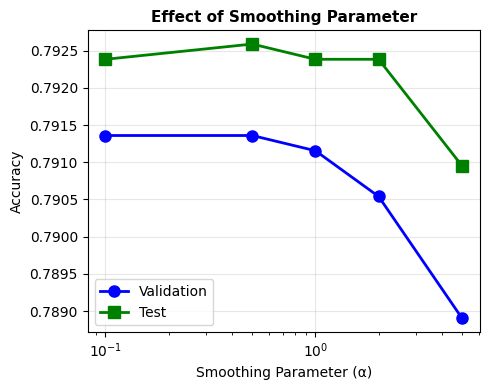

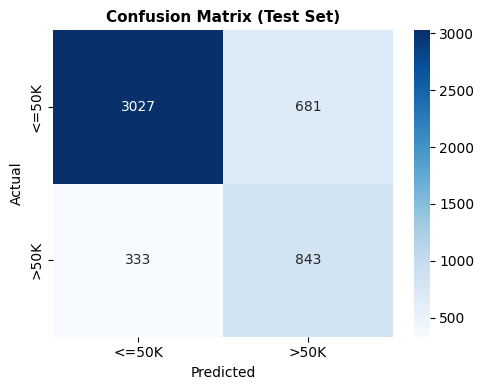

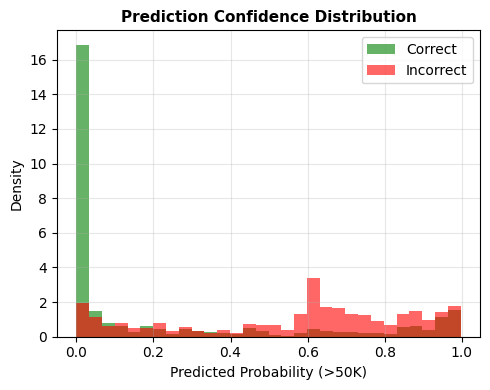

In [53]:
# 1. Smoothing parameter comparison
fig1, ax1 = plt.subplots(1, 1, figsize=(5, 4))
alphas_plot = [r['alpha'] for r in results]
val_accs = [r['val_acc'] for r in results]
test_accs = [r['test_acc'] for r in results]

ax1.plot(alphas_plot, val_accs, 'o-', label='Validation', linewidth=2, markersize=8, color='blue')
ax1.plot(alphas_plot, test_accs, 's-', label='Test', linewidth=2, markersize=8, color='green')
ax1.set_xlabel('Smoothing Parameter (α)', fontsize=10)
ax1.set_ylabel('Accuracy', fontsize=10)
ax1.set_title('Effect of Smoothing Parameter', fontsize=11, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')
plt.tight_layout()
plt.savefig('smoothing_parameter.png', dpi=150, bbox_inches='tight')
plt.show()

# 2. Confusion matrix
fig2, ax2 = plt.subplots(1, 1, figsize=(5, 4))
our_test_pred = nb_best.predict(X_test)
cm = confusion_matrix(y_test, our_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2, 
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
ax2.set_ylabel('Actual', fontsize=10)
ax2.set_xlabel('Predicted', fontsize=10)
ax2.set_title('Confusion Matrix (Test Set)', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# 3. Probability distribution
fig3, ax3 = plt.subplots(1, 1, figsize=(5, 4))
probs_test = nb_best.predict_proba(X_test)
pos_probs_test = probs_test[:, 1]
correct = our_test_pred == y_test

ax3.hist(pos_probs_test[correct], bins=30, alpha=0.6, label='Correct', color='green', density=True)
ax3.hist(pos_probs_test[~correct], bins=30, alpha=0.6, label='Incorrect', color='red', density=True)
ax3.set_xlabel('Predicted Probability (>50K)', fontsize=10)
ax3.set_ylabel('Density', fontsize=10)
ax3.set_title('Prediction Confidence Distribution', fontsize=11, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


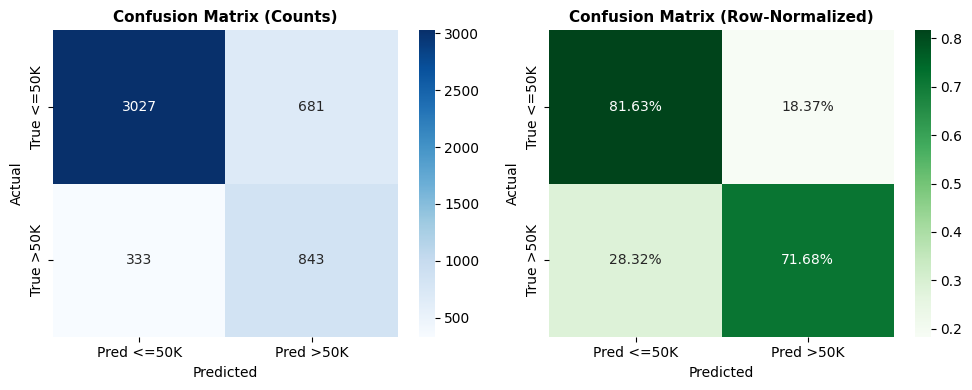


Per-Feature Univariate Naïve Bayes Performance (Validation Set):
  workclass            | Acc: 0.7604 | F1: 0.1333
  education            | Acc: 0.7795 | F1: 0.3265
  marital-status       | Acc: 0.7590 | F1: 0.0034
  occupation           | Acc: 0.7592 | F1: 0.0000
  relationship         | Acc: 0.7592 | F1: 0.0000
  marital-status       | Acc: 0.7590 | F1: 0.0034
  occupation           | Acc: 0.7592 | F1: 0.0000
  relationship         | Acc: 0.7592 | F1: 0.0000
  race                 | Acc: 0.7592 | F1: 0.0000
  sex                  | Acc: 0.7592 | F1: 0.0000
  race                 | Acc: 0.7592 | F1: 0.0000
  sex                  | Acc: 0.7592 | F1: 0.0000
  native-country       | Acc: 0.7592 | F1: 0.0000

Top features by F1 score:
       feature  accuracy       f1
     education  0.779484 0.326454
     workclass  0.760442 0.133333
marital-status  0.759009 0.003387
    occupation  0.759214 0.000000
  relationship  0.759214 0.000000
          race  0.759214 0.000000
           sex  0.7

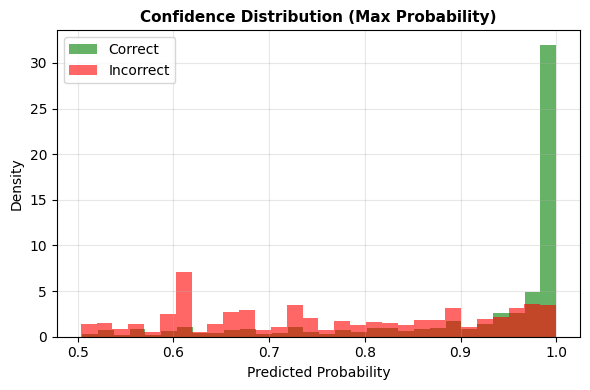

In [54]:
# Get predictions for analysis
our_test_pred = nb_best.predict(X_test)
cm = confusion_matrix(y_test, our_test_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Confusion Matrix visualization
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
            xticklabels=['Pred <=50K', 'Pred >50K'], 
            yticklabels=['True <=50K', 'True >50K'])
ax[0].set_title('Confusion Matrix (Counts)', fontweight='bold', fontsize=11)
ax[0].set_xlabel('Predicted', fontsize=10)
ax[0].set_ylabel('Actual', fontsize=10)

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', ax=ax[1],
            xticklabels=['Pred <=50K', 'Pred >50K'], 
            yticklabels=['True <=50K', 'True >50K'])
ax[1].set_title('Confusion Matrix (Row-Normalized)', fontweight='bold', fontsize=11)
ax[1].set_xlabel('Predicted', fontsize=10)
ax[1].set_ylabel('Actual', fontsize=10)

plt.tight_layout()
plt.show()

# Per-feature univariate analysis
print("\n" + "="*70)
print("Per-Feature Univariate Naïve Bayes Performance (Validation Set):")
print("="*70)

univariate_rows = []
for idx, feat in enumerate(categorical_features):
    # Train with single feature
    nb_uni = NaiveBayesDiscrete(alpha=best_alpha)
    nb_uni.fit(X_train[:, [idx]], y_train)
    y_uni = nb_uni.predict(X_val[:, [idx]])
    
    f1_uni = f1_score(y_val, y_uni, zero_division=0)
    acc_uni = accuracy(y_val, y_uni)
    
    univariate_rows.append({'feature': feat, 'accuracy': acc_uni, 'f1': f1_uni})
    print(f"  {feat:20s} | Acc: {acc_uni:.4f} | F1: {f1_uni:.4f}")

univariate_df = pd.DataFrame(univariate_rows).sort_values('f1', ascending=False)
print("\nTop features by F1 score:")
print(univariate_df.to_string(index=False))

# Confidence analysis
probs_test = nb_best.predict_proba(X_test)
confidence_correct = probs_test[our_test_pred == y_test]
confidence_incorrect = probs_test[our_test_pred != y_test]

print("\n" + "="*70)
print("Confidence Analysis:")
print("="*70)
print(f"Mean confidence (correct):   {confidence_correct.max(axis=1).mean():.4f}")
print(f"Mean confidence (incorrect): {confidence_incorrect.max(axis=1).mean():.4f}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(confidence_correct.max(axis=1), bins=30, alpha=0.6, label='Correct', color='green', density=True)
ax.hist(confidence_incorrect.max(axis=1), bins=30, alpha=0.6, label='Incorrect', color='red', density=True)
ax.set_title('Confidence Distribution (Max Probability)', fontweight='bold', fontsize=11)
ax.set_xlabel('Predicted Probability', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

